# Embedded ML - Lab 1.2: Model Compression

In this lab you are asked to create a compressed verion of an ANNs model. You are not allowed to use ML libraries such as SciKit-learn, PyTorch or TensorFlow, but you are allowed to use standard libraries such as math, numpy and matplotlib if needed. You are given some code but you are expected to write some more and be able to explain and modify everything. This lab is essential for you to grasp the details of some of the most important techniques for compressing or making ML models more efficient: quantization and pruning.

### Learning outcomes


* Explain the basic concepts of compression in ANNs
* Apply range tuning and centering when doing quantization
* Calculate and analyze the impact of quantization and pruning on memory and computing

### Naive quantization
Quantization means reducing the precission of model parameters and mainly targets weights, since they represent the most volumne of memory and processing in ANNs.

Take the code from the last part of Lab 1.1 (MNIST model) and add methods to export and import weights to and from a binary file, making sure both processes work with your code in such a way that you don't have to train every time you want to run inference, but insted, the wieghts are loaded into the model when needed. Investigate which serialization/desarialization options exist in Python and choose one that you understand.

Then, create two additional inference methods: FP16 and INT8. The FP16 method should treat all computations in the network involving the weights, as 16-bit floating-point. The INT8 method should work with 8-bit integers instead. In both cases, use the native datatype conversion methods. Investigate the NumPy methods available to enforce the desired datatypes.

Run the two quantized models and compare them with the baseline in terms of model size, accuracy and latency.

#### Load MNIST

#### Load Dataset in Numpy arrays

In [ ]:
import kagglehub
!pip install idx2numpy
import idx2numpy
import os
import numpy as np
import time
import copy
# Download latest version
PATH = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", PATH)

!cp -r {PATH} /content/

contenido = os.listdir(PATH)

def aplanar_data(X):
  return np.array([i.flatten() for i in (np.array(X))])
def one_hot_encodding(y, dim = 10):
  vector = (np.zeros((1,dim))).flatten()
  vector[y] = 1
  return vector
def normalizar(X):
  return X/abs(max(X))

file_xtest ="t10k-images.idx3-ubyte"
file_ytest ="t10k-labels.idx1-ubyte"
file_xtrain="train-images.idx3-ubyte"
file_ytrain="train-labels.idx1-ubyte"

data_train_X = aplanar_data(idx2numpy.convert_from_file(os.path.join(PATH, file_xtrain)))
data_train_X = np.array([normalizar(x) for x in data_train_X])


data_train_y = (idx2numpy.convert_from_file(os.path.join(PATH, file_ytrain)))
data_train_y = np.array([one_hot_encodding(v) for v in data_train_y])

data_test_X = aplanar_data(idx2numpy.convert_from_file(os.path.join(PATH, file_xtest)))
data_test_X = np.array([normalizar(x) for x in data_test_X])


data_test_y = (idx2numpy.convert_from_file(os.path.join(PATH, file_ytest)))

data_test_y = np.array([one_hot_encodding(v) for v in data_test_y])

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=7e473b5422ffcbdb59fa51f9b36e8f99585e7d51e375aa8ac2fbb6a801e8b103
  Stored in directory: /root/.cache/pip/wheels/87/e5/e7/70fc742b3645ddf9d392f766feccbcc95cb3a3c806f8588af0
Successfully built idx2numpy
Path to dataset files: /kaggle/input/mnist-dataset


#### Train MNIST

In [ ]:
np.random.seed(42)

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases
        #The correct size should be hidden_size x input
        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.bias_input_hidden = np.zeros((1, self.hidden_size))
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)
        self.bias_hidden_output = np.zeros((1, self.output_size))
    def load_saved_weights(self, weights):
      # 'weights' es una lista
      self.weights_input_hidden = weights[0]
      self.bias_input_hidden = weights[1]
      self.weights_hidden_output = weights[2]
      self.bias_hidden_output = weights[3]

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def convertir_pesos(self, dtype):
      self.weights_input_hidden = self.weights_input_hidden.astype(dtype)
      self.bias_input_hidden = self.bias_input_hidden.astype(dtype)
      self.weights_hidden_output = self.weights_hidden_output.astype(dtype)
      self.bias_hidden_output = self.bias_hidden_output.astype(dtype)

    def forward(self, x):
        # Forward propagation through the network...
        # Step 1: dot product between the input and the weights
        # that connect with the hidden layer.
        self.hidden_output = np.dot(x, self.weights_input_hidden) + self.bias_input_hidden

        self.hidden_output = self.sigmoid(self.hidden_output)
        # Step 2: dot product between the activations (outputs) of the
        # hidden layer and the weights that connect with the output layer.
        self.output = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output

        self.output = self.sigmoid(self.output)
        return self.output
    #-----------------------------
    #------------NEW: FORWARD 16------------------------------------
    #-----------------------------
    # def forward_float16(self, x):
    #   self.hidden_output = np.float16(np.dot(np.float16(x), np.float16(self.weights_input_hidden)) + np.float16(self.bias_input_hidden))

    #   self.hidden_output = np.float16(self.sigmoid(self.hidden_output))
    #   self.output = np.float16(np.dot(self.hidden_output, np.float16(self.weights_hidden_output)) + np.float16(self.bias_hidden_output))

    #   self.output = np.float16(self.sigmoid(self.output))
    #   return self.output
    def forward_float16(self, x):
      self.hidden_output = (np.dot(np.float16(x), (self.weights_input_hidden)) + self.bias_input_hidden)

      self.hidden_output = np.float16(self.sigmoid(self.hidden_output))
      self.output = (np.dot(self.hidden_output, (self.weights_hidden_output)) + (self.bias_hidden_output))

      self.output = np.float16(self.sigmoid(self.output))
      return self.output
    #------------------------------
    #------------NEW: int8-------------------------------------
    #------------------------------
    def forward_int8(self, x):
      self.hidden_output = np.int8(np.dot(np.int8(x), np.int8(self.weights_input_hidden)) + np.int8(self.bias_input_hidden))

      self.hidden_output = np.int8(self.sigmoid(self.hidden_output))
      self.output = np.int8(np.dot(self.hidden_output, np.int8(self.weights_hidden_output)) + np.int8(self.bias_hidden_output))

      self.output = np.int8(self.sigmoid(self.output))

      return self.output

    def backward(self, x, y, output, learning_rate):
        # Backpropagation and weight updates
        self.error = y - output
        d_output = self.error * self.sigmoid_derivative(output)

        self.hidden_error = d_output.dot(self.weights_hidden_output.T)
        d_hidden = self.hidden_error * self.sigmoid_derivative(self.hidden_output)

        self.weights_hidden_output += self.hidden_output.T.dot(d_output) * learning_rate
        self.bias_hidden_output += np.sum(d_output, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden += x.T.dot(d_hidden) * learning_rate
        self.bias_input_hidden += np.sum(d_hidden, axis=0, keepdims=True) * learning_rate

    def train(self, x, y, epochs, learning_rate):
        error = 0
        self.track_loss = []
        for epoch in range(epochs):
          #for x, y in zip(X,Y):
          output = (self.forward(x))
          self.backward(x, y, output, learning_rate)
          if epoch % 10 == 0:
              error = np.mean(np.square(y - output))
              self.track_loss.append(float(error))
              if epoch % 100 == 0:
                print(f'Epoch {epoch}: Loss = {error:.4f}')

def test_model(x,y, my_nn, method):
  '''
  Test the trained model
  x: test data
  y: test labels
  my_nn: trained model

  return: accuracy and time
  '''
  tp = 0
  start_time = time.time()
  if method == 'FP32':
    output = my_nn.forward(x[0])
  elif method == 'FP16':
    my_nn.convertir_pesos(np.float16)
    output = my_nn.forward_float16(x[0])
  elif method == 'INT8':
    my_nn.convertir_pesos(np.int8)
    output = my_nn.forward_int8(x[0])
  else:
    print("Method not supported")
    return
  time_infer = time.time() - start_time
  if output.argmax() == y[0].argmax():
        tp += 1

  for i in range(1, x.shape[0]):
      if method == 'FP32':
        output = my_nn.forward(x[i])
      elif method == 'FP16':
        my_nn.convertir_pesos(np.float16)
        output = my_nn.forward_float16(x[i])
      elif method == 'INT8':
        my_nn.convertir_pesos(np.int8)
        output = my_nn.forward_int8(x[i])
      else:
        print("Method not supported")
        return

      if output.argmax() == y[i].argmax():
        tp += 1
  print(f"Accuracy: {(tp/len(y)):2f}")
  print(f"Time: {time_infer:.8f}")
  return tp/len(y), time_infer


#### Run Model

In [ ]:
# COPY HERE YOUR MNIST MODEL CODE
neurons = 10
epochs = 1000
learning_rate = 0.01
size = 1000
#Load Model
nn_v1 = NeuralNetwork(input_size=784, hidden_size= neurons, output_size=10)

#pretrained ?
#p = str(input('Wanna load weights? (y/n): '))
#train
nn_v1.train(data_train_X[:size], data_train_y[:size],
            epochs=epochs,
            learning_rate= learning_rate
            )

Epoch 0: Loss = 0.3787
Epoch 100: Loss = 0.0556
Epoch 200: Loss = 0.0372
Epoch 300: Loss = 0.0242
Epoch 400: Loss = 0.0179
Epoch 500: Loss = 0.0142
Epoch 600: Loss = 0.0122
Epoch 700: Loss = 0.0107
Epoch 800: Loss = 0.0094
Epoch 900: Loss = 0.0080


#### Test with new Methods and Save Weights

In [ ]:
import os
def r_weights(modelo, dtype):
  #Returns weights in a list
  modelo.convertir_pesos(dtype)
  return [modelo.weights_input_hidden,
          modelo.bias_input_hidden,
          modelo.weights_hidden_output,
          modelo.bias_hidden_output]

def size_file(ruta_archivo):
  #Get the size of files
  size = os.path.getsize(ruta_archivo)
  print(f"El tamaño del archivo '{ruta_archivo}' es: {size} bytes")
  return size

def save_weights_binary(weights, weights_file):
  # store all weights in a binary file
  with open(weights_file, 'wb') as f:
    np.savez(f, weights_input_hidden=weights[0],
              bias_input_hidden=weights[1],
              weights_hidden_output=weights[2],
              bias_hidden_output=weights[3])

def load_weights_binary(weights_file):
  #Returns the list of the Matrix weights from the binary file
  with open(weights_file, 'rb') as f:
      data = np.load(f)
      weights_input_hidden = data['weights_input_hidden']
      bias_input_hidden = data['bias_input_hidden']
      weights_hidden_output = data['weights_hidden_output']
      bias_hidden_output = data['bias_hidden_output']
  return [weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output]

#-----Stats Variables--------------
stats = {'size':{},'acc' :{}, 'time':{}}
#------TEST DATA-------------------
test_x = data_test_X[:int(size*0.3)]
test_y = data_test_y[:int(size*0.3)]
#------Nombre de archivos binarios------
weights_file_fp32 = "weights_fp32.bin"
weights_file_fp16 = "weights_fp16.bin"
weights_file_int8 = "weights_int8.bin"
#-----------FP32----------------------------
weights = copy.deepcopy(r_weights(nn_v1, np.float32)) #Weights in list format
save_weights_binary(weights, weights_file_fp32) # save in binary file

weights_model = load_weights_binary(weights_file_fp32) #load from binary file
a = test_model(test_x, test_y, nn_v1,
               method = 'FP32')
stats['acc']['FP32'] = a[0]
stats['time']['FP32'] = a[1]
stats['size']['FP32'] = size_file(weights_file_fp32)
#--------------- FP16----------------------
nn_v1.load_saved_weights(weights)

weights_fp16 = copy.deepcopy(r_weights(nn_v1, np.float16))
save_weights_binary(weights_fp16, weights_file_fp16)
#read binary file
weights_fp16 = load_weights_binary(weights_file_fp16)
#load weights to model
nn_v1.load_saved_weights(weights_fp16)

b = test_model(test_x, test_y, nn_v1,
               method = 'FP16')

stats['acc']['FP16'] = b[0]
stats['time']['FP16'] = b[1]
stats['size']['FP16'] = size_file(weights_file_fp16)

#------------------INT8----------------------
weights_int8 = copy.deepcopy(r_weights(nn_v1, np.int8))
save_weights_binary(weights_int8, weights_file_int8)

weights_int8 = load_weights_binary(weights_file_int8)
nn_v1.load_saved_weights(weights_int8)

c = test_model(test_x, test_y, nn_v1,
               method = 'INT8')

stats['acc']['INT8'] = c[0]
stats['time']['INT8'] = c[1]
stats['size']['INT8'] = size_file(weights_file_int8)
#Imprimir tamaño de los modelos almacenados en binario
s_a = size_file(weights_file_fp32)
s_b = size_file(weights_file_fp16)
s_c = size_file(weights_file_int8)

sizes = [s_a, s_b, s_c] #tamaños de archivos
stats1 = [a,b,c] # Accuracy

Accuracy: 0.780000
Time: 0.00013018
El tamaño del archivo 'weights_fp32.bin' es: 32942 bytes
Accuracy: 0.780000
Time: 0.00069618
El tamaño del archivo 'weights_fp16.bin' es: 17022 bytes
Accuracy: 0.080000
Time: 0.00012326
El tamaño del archivo 'weights_int8.bin' es: 9062 bytes
El tamaño del archivo 'weights_fp32.bin' es: 32942 bytes
El tamaño del archivo 'weights_fp16.bin' es: 17022 bytes
El tamaño del archivo 'weights_int8.bin' es: 9062 bytes


<ipython-input-67-29772c57603c>:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


#### Comparing model size, accuracy and latency

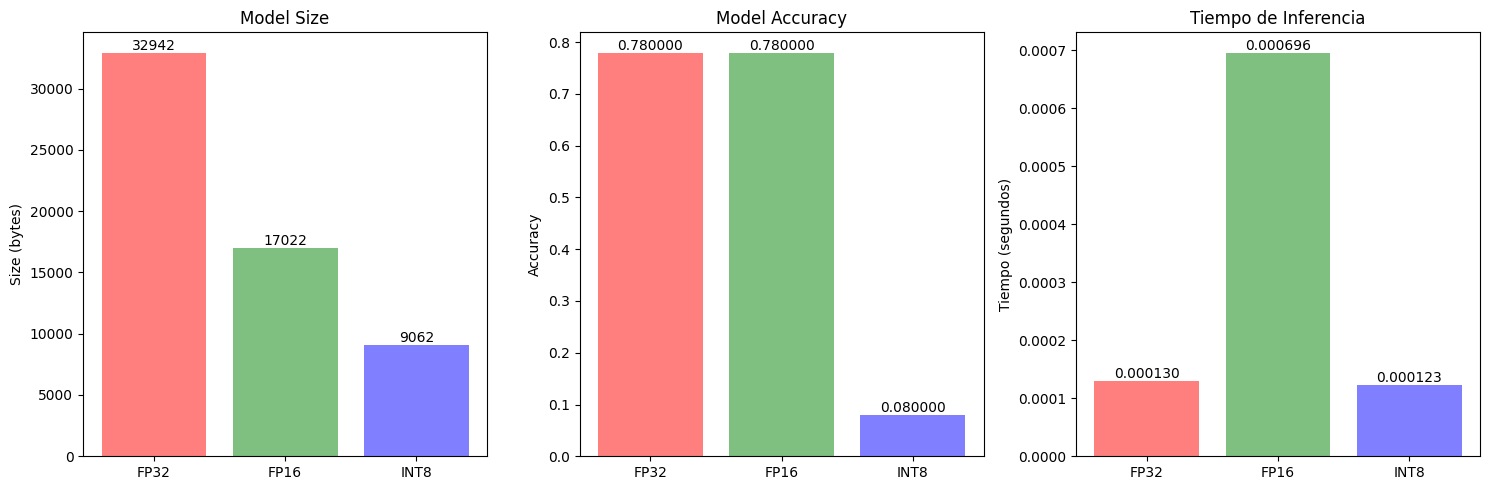

In [ ]:
import matplotlib.pyplot as plt

# Datos de ejemplo (reemplaza con tus datos reales)
sizes = [s_a, s_b, s_c]
accuracy = [stats1[0][0], stats1[1][0], stats1[2][0]]
times = [stats1[0][1], stats1[1][1], stats1[2][1]]
labels = ['FP32', 'FP16', 'INT8']

x = range(len(labels))  # Indices para las barras

# Crea la figura y los subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas
colores = ['r', 'g', 'b']
# Gráfico de tamaños
axes[0].bar(x, sizes, color = colores, alpha = 0.5)
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_ylabel('Size (bytes)')
axes[0].set_title('Model Size')

# Gráfico de precisión
axes[1].bar(x, accuracy, color=colores, alpha = 0.5)
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy')

# Gráfico de tiempo de ejecución
axes[2].bar(x, times, color=colores, alpha = 0.5)
axes[2].set_xticks(x)
axes[2].set_xticklabels(labels)
axes[2].set_ylabel('Tiempo (segundos)')
axes[2].set_title('Tiempo de Inferencia')
for i, v in enumerate(times):
    axes[2].text(i, v, f'{v:.6f}', ha='center', va='bottom')
for i, v in enumerate(accuracy):
    axes[1].text(i, v, f'{v:.6f}', ha='center', va='bottom')
for i, v in enumerate(sizes):
    axes[0].text(i, v, v, ha='center', va='bottom')
plt.tight_layout()

plt.show()


### Range tuning and centering
For quantization to be effective, you should smartly choose the range of numbers you will code with the fewer bits available after quantization. To do so, you should evaluate the dynamic ranges of the variables to be quantized and map the values using that as the full range.

Make a histogram plot of the model weights in order to verify their range. Then write a function to quantize the weights stored in the exported binary file to INT8 and store the resulting weights in another file. Finally, run again the INT8 quantized inference with the newly computed weights and compare with the previous versions using the same metrics.

In [ ]:
def flat_weights(weights):
  total_pesos = []
  for i in range(len(weights)):
    total_pesos.extend(weights[i].flatten())
  return total_pesos
def plot_histogram(weights, title ='Float32'):
  # plot a histogram of all model weights
  total_pesos = flat_weights(weights)
  plt.hist(total_pesos, bins=50)
  plt.xlabel('Weight Value')
  plt.ylabel('Frequency')
  plt.title(f'Histogram of Model Weights {title}')
  plt.show()
def plot_compare_histogram(weights1, weights2, title: list):
  pesos1 = flat_weights(weights1)
  pesos2 = flat_weights(weights2)
  fig, axs = plt.subplots(1, 2, figsize=(15,5))
  plt.subplot(1,2,1)
  plt.hist(pesos1, bins=50, color ='b', alpha = 0.5)
  plt.xlabel('Weight Value')
  plt.ylabel('Frequency')
  plt.title(f'Weights Original - {title[0]}')

  plt.subplot(1,2,2)
  plt.hist(pesos2, bins=50, color ='g', alpha = 0.5)
  plt.xlabel('Weight Value')
  plt.ylabel('Frequency')
  plt.title(f'Weights - {title[1]}')
  plt.show()
##############################
#------quantize_INT8----------
#############################
def quantize_INT8(weights_clip):
  # Weights: Numpy array. It's list of np Matrix
  # quantize to INT8 the model weights
  def quantize_layer(weights_layer):
    weights_int8 = np.int8(np.array(weights_layer) * scale + zero_point)
    return weights_int8

  w_int8 = []
  flat_w = flat_weights(weights_clip)
  max_weight = np.max(flat_w)
  min_weight = np.min(flat_w)
  scale =  255 / (max_weight - min_weight) # 256 levels in int8 (0-255)
  zero_point = -round(scale * min_weight) - 128

  for i,capa in enumerate(weights_clip):
    w_int8.append(quantize_layer(copy.deepcopy(capa)))
  return w_int8

def recortar_extremos(weights: list, th: float=2) -> list:
  # It will clip/sature extrem values given a threshold
  w_clip = []
  for i, capa in enumerate(weights):
    w = np.clip(capa, -th, th)
    w_clip.append(w)
  return w_clip



##### **Plot original weights**

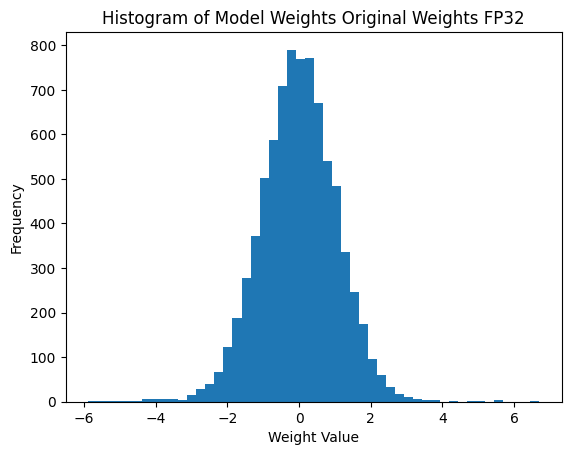

In [ ]:
plot_histogram(weights, 'Original Weights FP32')

##### **Compare FP32 and Quantized INT8 weights Clipped**

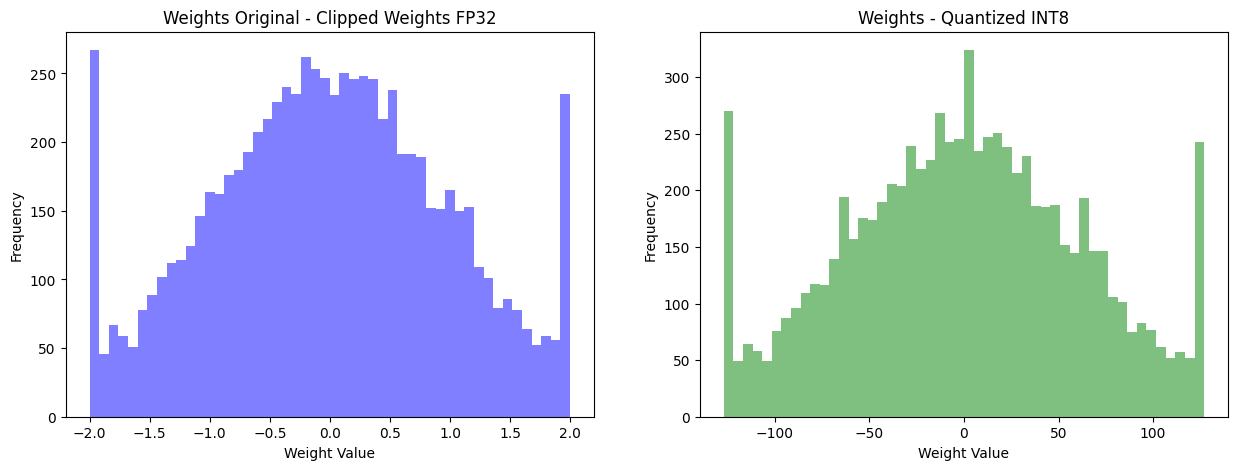

In [ ]:
limite = 2
# Original weights
weights_model = load_weights_binary(weights_file_fp32) #load from binary file
w_clip = recortar_extremos(copy.deepcopy(weights_model), limite)
# Quantize weights
w_int8 = quantize_INT8(copy.deepcopy(w_clip))
#Save in a binary file
w_int8_binary_file = 'W_INT8_QUANTIZED.bin'
save_weights_binary(w_int8, w_int8_binary_file)
w_int8_quant = load_weights_binary(w_int8_binary_file)

plot_compare_histogram(w_clip, w_int8_quant, ['Clipped Weights FP32', 'Quantized INT8'])

##### **Generate Quantized Model**

In [ ]:
nn_int8_quant = NeuralNetwork(input_size=784, hidden_size= 10, output_size=10)
nn_int8_quant.load_saved_weights(w_int8_quant)

quant_acc = test_model(test_x, test_y, nn_int8_quant,
               method = 'FP32')
stats['acc']['INT8_QUANT'] = quant_acc[0]
stats['time']['INT8_QUANT'] = quant_acc[1]
stats['size']['INT8_QUANT'] = size_file(w_int8_binary_file)

Accuracy: 0.643333
Time: 0.00044346
El tamaño del archivo 'W_INT8_QUANTIZED.bin' es: 9062 bytes


<ipython-input-67-29772c57603c>:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


##### Plot Performance Metrics

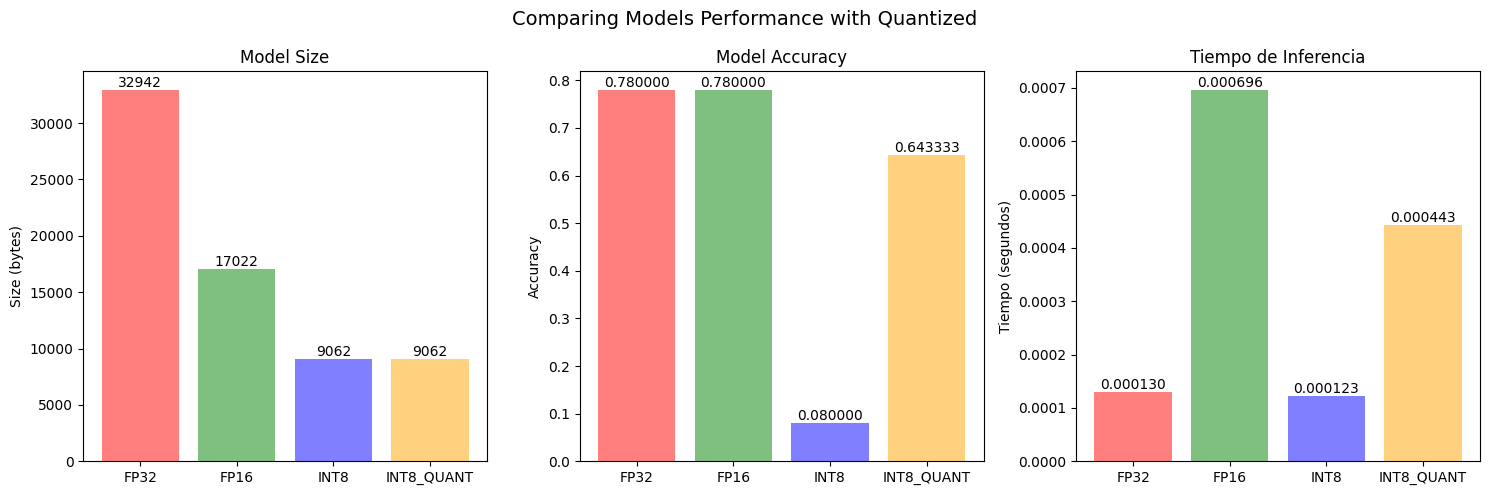

In [ ]:
labels = list(stats['acc'].keys())
sizes = list(stats['size'].values())
accuracy = list(stats['acc'].values())
times = list(stats['time'].values())

# Crear la figura y los subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colores = ['r', 'g', 'b', 'orange']

data = [sizes, accuracy, times]
titulos = ['Model Size', 'Model Accuracy', 'Tiempo de Inferencia']
ylabels = ['Size (bytes)', 'Accuracy', 'Tiempo (segundos)']

for i, ax in enumerate(axes):
    ax.bar(labels, data[i], color=colores, alpha = 0.5)
    ax.set_ylabel(ylabels[i])
    ax.set_title(titulos[i])
    for j, v in enumerate(data[i]):
        if i == 1 or i == 2:
            ax.text(j, v, f'{v:.6f}', ha='center', va='bottom')
        else:
            ax.text(j, v, v, ha='center', va='bottom')
plt.suptitle('Comparing Models Performance with Quantized', fontsize = 14)
plt.tight_layout()
plt.show()

## Pruning
Besides reducing precision for the network weights, we can also decide to eliminate network connections that do not contribute significantly to the model. This can be achieved by simply removing the connections whose weights are closest to zero.

In this part of the lab you are asked to generate three pruned versions of the original model by setting to zero some of the weights:


*   Set to zero the smallest 10% of weights
*   Set to zero the smallest 30% of weights
*   Set to zero the smallest 50% of weights

Report the accuracy for each model against the estimated memory savings.



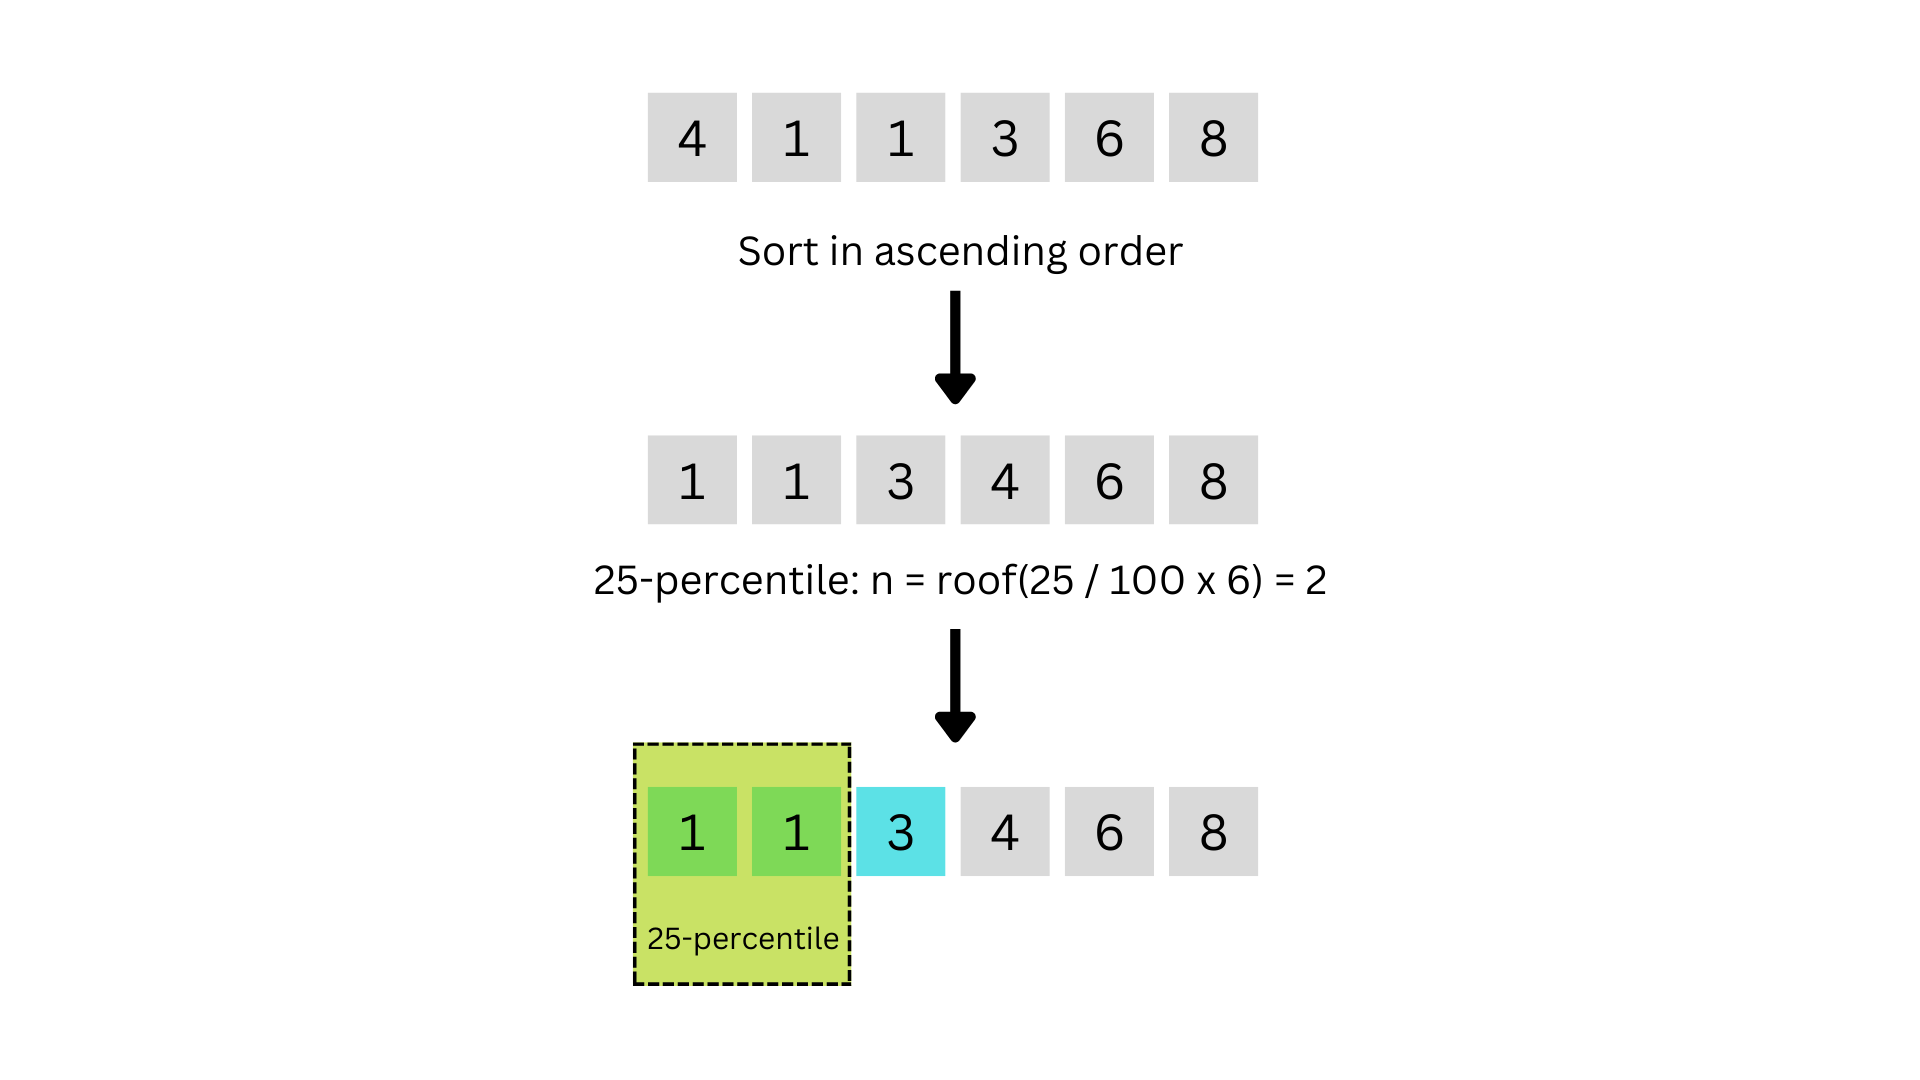

In [ ]:
def prune_model(weights, percentage):
  # weights (list): List of many weights arrays
  # It will iterate each layer (hidden neurons, bias, hidden output, bias)
  weights_pruned = []
  #w = flat_weights(weights)
  #percentil = np.percentile(np.abs(w), percentage)

  for i, capa in enumerate(weights):
    # pasar matrz (capa) a lista 1D
    w = capa.flatten()
    # calcular percentil
    percentil = np.percentile(np.abs(w), percentage)
    # aplicar prunning
    w[np.abs(w) < percentil] = 0
    # agregar a lista de nuevos pesos
    weights_pruned.append(w.reshape(capa.shape))

  return weights_pruned


##### **Prunning Version1**

In this version, prunning process has been evaluated in the original FP32 weights. No clipped or range has been applied

In [ ]:
def plot_histogram_pruned(pruned_groups, lista):
  # plot comparision between pruned weights histograms
  fig, axes = plt.subplots(1, len(pruned_groups), figsize=(15, 5))
  for i, ax in enumerate(axes):
    w = flat_weights(pruned_groups[str(lista[i])])
    ax.hist(w, bins = 50, alpha = 0.6)
    ax.set_title(f'Prune {lista[i]}%')
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Frequency')
  plt.suptitle('Histogram of Pruned Weights Original Weights FP32')
  plt.tight_layout()
  plt.show()



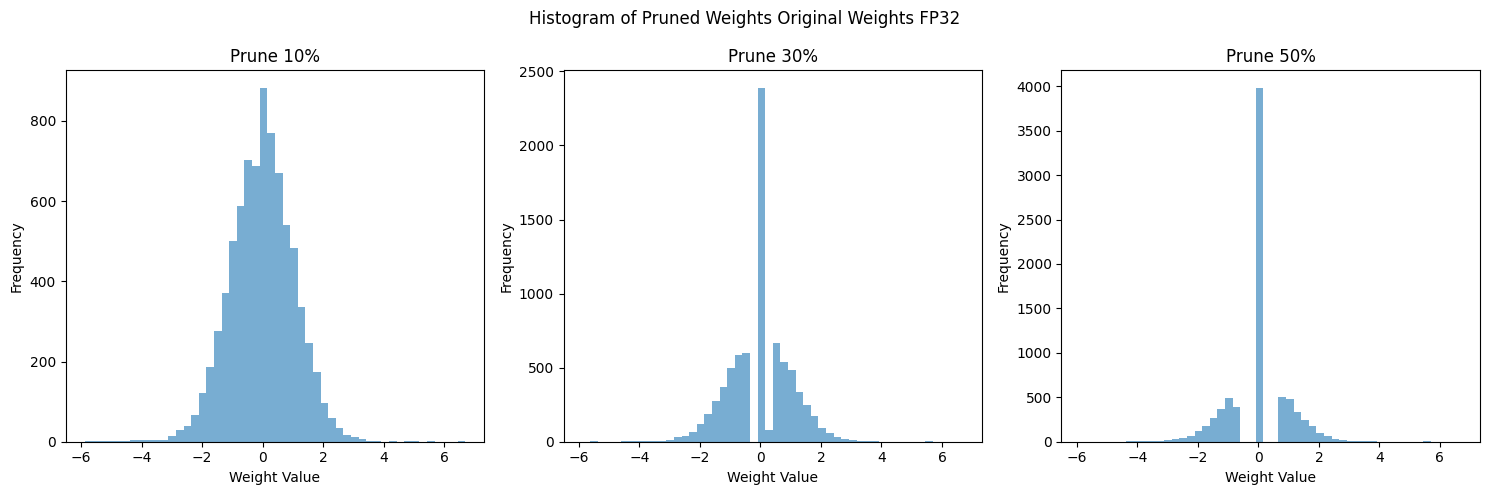

In [ ]:
#Prune Original weights (No range and)
prune_perc = [10,30,50]
pruned = {}

for p in prune_perc:
  pruned[str(p)] = prune_model(weights_model, p)


plot_histogram_pruned(pruned, prune_perc)

In [ ]:
stats_pruned = {'10' : {}, '30' : {}, '50' : {}}
for i in pruned:
  nn_int8_quant.load_saved_weights(pruned[i])

  quant_acc = test_model(test_x, test_y, nn_int8_quant,
                method = 'FP32')
  stats_pruned[i]['acc'] = quant_acc[0]
  stats_pruned[i]['time'] = quant_acc[1]
  file_binary = f'pruned_{i}.bin'
  #eliminar ceros:
  x = []
  for capa in pruned[i]:
    f = capa.flatten()
    n = np.delete(f, np.where(f == 0))
    x.append(n)
  save_weights_binary(x, file_binary)
  stats_pruned[i]['size'] = os.path.getsize(file_binary)
  print(f'Size: {stats_pruned[i]["size"]}')


Accuracy: 0.740000
Time: 0.00381207
Size: 29758
Accuracy: 0.753333
Time: 0.00010324
Size: 23390
Accuracy: 0.650000
Time: 0.00009418
Size: 17022


##### Prunning Version 2

In this version, I used the INT8 weights quantized.

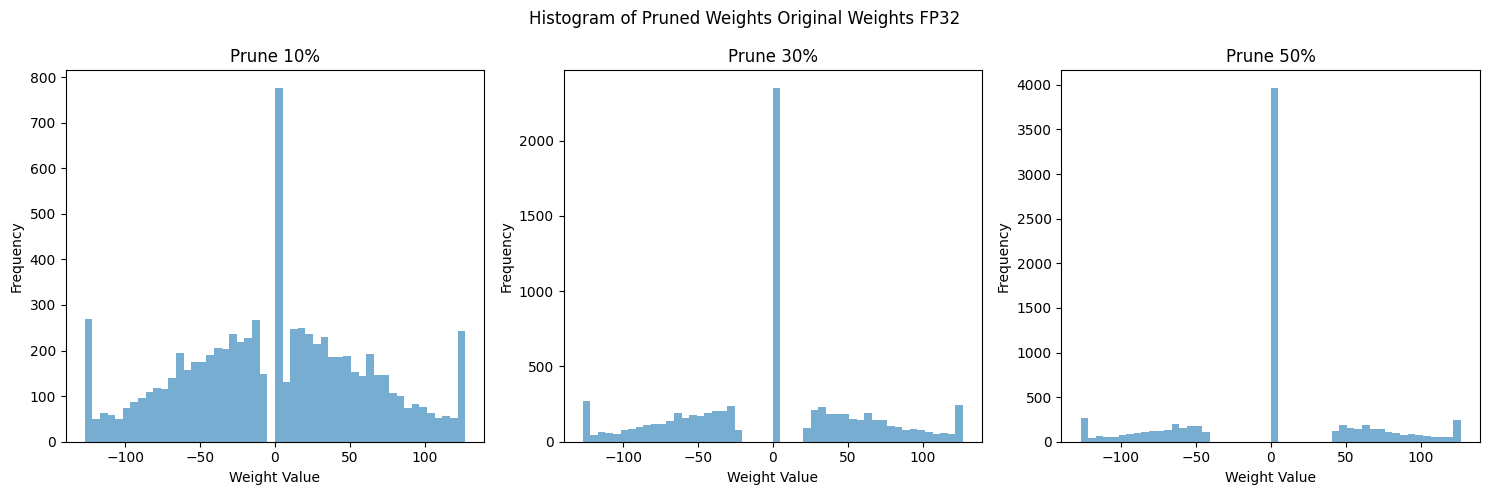

In [ ]:
pruned = {}

for p in prune_perc:
  pruned[str(p)] = prune_model(w_int8_quant, p)


plot_histogram_pruned(pruned, prune_perc)


In [ ]:
stats_pruned2 = {'10' : {}, '30' : {}, '50' : {}}
for i in pruned:
  nn_int8_quant.load_saved_weights(pruned[i])

  quant_acc = test_model(test_x, test_y, nn_int8_quant,
                method = 'FP32')
  stats_pruned2[i]['acc'] = quant_acc[0]
  stats_pruned2[i]['time'] = quant_acc[1]
  file_binary = f'pruned_{i}.bin'
  #eliminar ceros:
  x = []
  for capa in pruned[i]:
    f = capa.flatten()
    n = np.delete(f, np.where(f == 0))
    x.append(n)
  save_weights_binary(x, file_binary)
  stats_pruned2[i]['size'] = os.path.getsize(file_binary)
  print(f'Size: {stats_pruned2[i]["size"]}')


Accuracy: 0.603333
Time: 0.00052381
Size: 8286
Accuracy: 0.556667
Time: 0.00012565
Size: 6712
Accuracy: 0.576667
Time: 0.00011396
Size: 5097


<ipython-input-67-29772c57603c>:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Comparative of FP32 model after prunning

In [ ]:
import pandas as pd
df = pd.DataFrame(stats_pruned)
df2 = pd.DataFrame(stats_pruned2)

df.T

,acc,time,size
10,0.740000,0.003812,29758.0
30,0.753333,0.000103,23390.0
50,0.650000,0.000094,17022.0


Comparative of INT8 quantized model after prunning

In [ ]:
df2.T

,acc,time,size
10,0.603333,0.000524,8286.0
30,0.556667,0.000126,6712.0
50,0.576667,0.000114,5097.0


## Analysis

Discuss the following questions based on the lab experiments and the theory studied:


*   What are the advantages an disadvantages of storing model weights in different formats?
*   How much reduction in model memory requirements can be achieved by each of the versions obtained?
*   What are the posible computational advantages of the obtained models and how do they depend on the hardware?





---

1. The advantages are the capability to reduce the size of the model in order to deploy it in a device with a different and reduced precision of the hardware, for example in embedded systems or microcontrollers that doesn't support 32 or 64 bits. It will allow to skip the emulation process of a model that doesn't support the data. Some disadvatages include a big model size in the case of FP32, and a lower precision in FP16 and INT8 models, it might produce accuracy loss. However, these problems can be addresed after an adequated range and centering processes. Depending on the aplication one of the models must be selected.
Also, after applying range, quantitization and an strategy of  clipping (which will help to set up the new range of data) it can be observed that the new range will allow us to distribute and map the data in an equitable and reasonable manner, reducing the loss of information when we want to approximate some values.
2. When converting the type of data from FP32 to FP16 and INT8, it can be noticed a sucesive reduction in each model, showing that storing data in less resolution. The FP16 will in 50% less space than a FP32 model, and a INT8 will use 50% and 75% less memory than a FP16 and FP32 respectively.

When applying range and centering the model size will be the same, but when applying prunning, if the percetage of small prunned data setted to zero is deleted, the model will be stored in less space. The new size will be determinated by how many data satisfy the the condition to be prunned

3. The possibles computational advantages might involve the reduction of memory, reducing the time and the implementation for specific hardware that only can support and process lower-precision formats. If the hardware doesn't support the format (e.g the hardware is a FP16 and it's trying to run a FP32 model) it might take more time while emulating the new format.
